# Imports & Read File

In [164]:
import pandas as pd
import nltk
nltk.download('wordnet')
from nameparser import HumanName
import matplotlib.pyplot as plt
import math
import wget
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sbyli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Input

In [3]:
cluster_data = pd.read_excel('data with cluster.xlsx')

##title & abstract
# embedding = "embedding_TA"
##full-text
embedding = np.loadtxt("embeddings of long texts") 

#number of articles
iter_len = len(cluster_data)

# Wordcloud using title & abstract texts

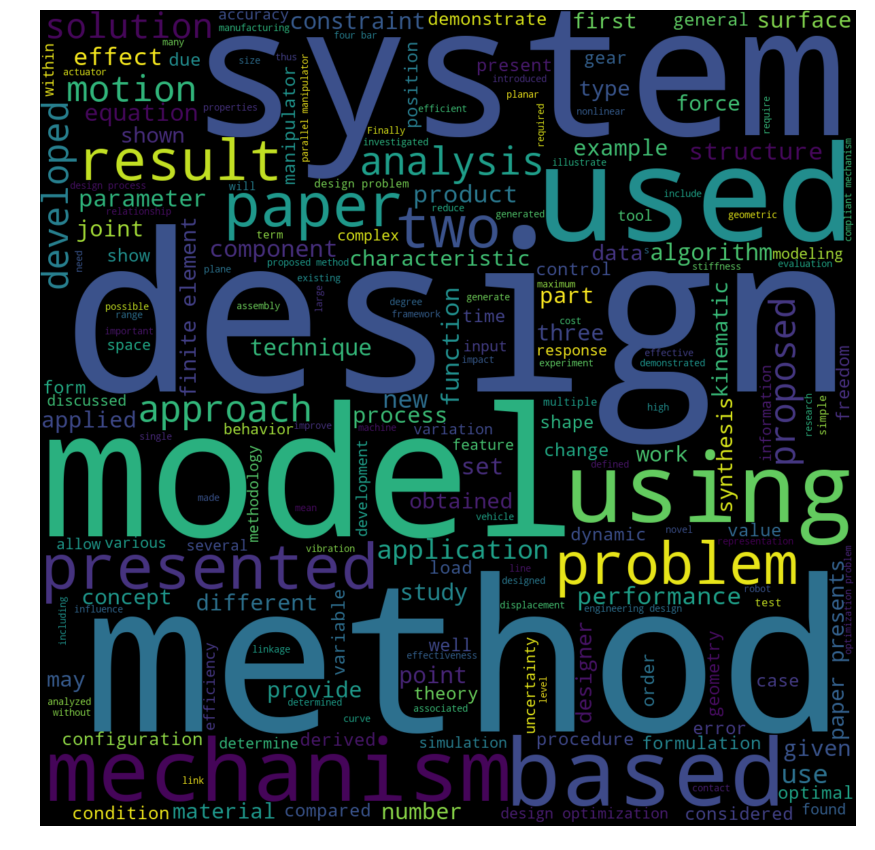

In [262]:
from wordcloud import STOPWORDS

cluster_data = cluster_data.astype({'title': str, 'abstract': str})
title = list(cluster_data['title'])
abstract = list(cluster_data['abstract'])

text1 = ' '.join(title)
text2 = ' '.join(abstract)
text = ' '.join([text1, text2])

##customize the domain specific stopwords here
stop_words = ['one'] + list(STOPWORDS)

wordcloud = WordCloud(stopwords = stop_words, background_color="black",width=1200, height=1200)
wordcloud.generate_from_text(text)
plt.figure(figsize=(15,15) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.savefig('plots/wordcloud_topic.png', dpi = 1000, bbox_inches='tight')
plt.savefig('plots/wordcloud TA.png', bbox_inches='tight')
plt.show()

# function definition

In [4]:
def catch(func, handle=lambda e: e, *args, **kwargs):
    '''
    exception catch function for use in comprehensions
    '''
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return []

In [5]:
def process_data(data):
    '''
    data is a dictionary
    returns dictionary with processed data
    this function splits data items in a cell
    '''
    res = {}
  
    #copies fields that stay the same
    samefield = {'year', 'abstract', 'doi', 'year', 'title', 'citation_info', 'pdf_link', 'author affiliation'}
    for field in samefield:
        res[field] = list(data[field][:])

    #splits field on split_chara, and removes prefixes
    diff_field = {'authors', 'issue_section', 'topics', 'author affiliation'}
    for key in diff_field: #iterate over keys
        split_chara = ''
        start = 0
        if key == 'authors':
            split_chara = ', '
            start = 0
        elif key == 'topics':
            split_chara = ',\n'
            start = 8
        elif key == 'issue_section':
            split_chara = ',\n'
            start = 15
        elif key == 'author affiliation':
            split_chara = ';'
            start = 0
        res[key] = np.array([catch(lambda : np.array(item[start:].split(split_chara))) for item in data[key]])
        # res[key] = [catch(lambda : item[start:].split(split_chara)) for item in data[key]]

    #removes str prefixes 'volume' and 'issue', and combines into list [vol, issue]
    res['volume_issue'] = [catch(lambda : [item.split(', ')[0][7:], item.split(', ')[1][6:]]) for item in data['issue']]

    return res

proc_data = process_data(cluster_data)
print(type(proc_data))

<class 'dict'>


In [6]:
def get_all_possible(fullname):
    '''
    WIP
  
    fullname is a HumanName object

    Example: Katherine K. Fu
    {K. K. Fu, Katherine K. Fu, Katherine Fu}

    Example: K.K. Fu
    {K. K. Fu, K. Fu}

    Example: Katherine Fu
    {K. Fu, Katherine Fu}
    '''
    poss = {}
    if len(fullname) == 3: #Katherine K. Fu or K. K. full
        print('hi')

    return poss

In [7]:
def filter_out(data):
    for i in range(len(data['issue_section'])):
        if isinstance(data['issue_section'][i], list):
            if data['issue_section'][i][0] in issue_section_nontopic:
                #print(data['issue_section'][i])
                for item in data:
                    #print(item)
                    print(data[item][i])
                    del data[item][i]
          
    return data

In [8]:
def dictdata(data_list_list):
    '''Iterate through list of authors, parse names using nameparser and add to dictionary
    While adding, compare produced name to names in dictionary. 
    store {'last name': {'initials': {'full': number of appearances}}}

    ---need to figure out how to work with differently formatted names
    for author_str in data_authors['authors']:
        author_list = author_str.split(', ')
        for author in author_list:
            name = HumanName(author)
            if name.last not in authors: #base case, author last name not yet seen before
                authors[name.last] = {name.initials: {name.full_name: [1]}}
            else: #author last name has been seen
                if name.full_name in authors[name.last]: #name have been seen
                    if isinstance(authors[name.last][name.full_name], str) #the seen name A is synonymous with another name B, points to key B 
                        authors[last][authors[name.last][name.full_name]] += 1 #adds to B count
                  else:
                    authors[name.last][name.full_name] += 1
                elif: #check if name in different format

    parameters: list of lists
    returns: dictionary {key: # occurrences in list}
  
    datadict = {}
    for data_list in data_list_list:
        try:
            for data in data_list:
                datadict[data] = datadict.get(data, 0) + 1
        except:
            continue

    return datadict
    '''
    datadict = nltk.FreqDist(data_list_list[0])
    for datalist in data_list_list[1:]:
        try: 
            datadict.update(datalist)
        except: continue
    return datadict

In [107]:
def get_id(col):
    '''
    col: the column name in cluster_data from which the information is extracted
    map author names / topics to the corresponding paper IDs
    '''
    dictx = {}
    if col == 'author_id':
        spliter = ', '
    elif col == 'topics':
        spliter = ','
        
    data = cluster_data
    data = data.astype({col: str})
    lst = list(data[col])
    for i in range(len(lst)):
        txt = lst[i].replace('Topics:\n','').replace('\n','')
        item = txt.split(spliter)
        for itemx in item:
            if itemx not in dictx.keys():
                dictx[itemx] = [i]
            dictx[itemx] = dictx[itemx] + [i]
    return dictx

In [109]:
def get_embedding(data,col1,col2):
    '''
    get the embeddings of an author or a topic by averaging embeddings of papers associated to this author / topic
    data: the spreadsheet containing the (cleaned) topic / author information
    col1: the column name in data. This column should contain the list of topics / authors for which we generate embeddings.
    col2: the column name in cluster_data which maps the topics/ authors to the papers
    '''
    item_lst = list(set(data[col1]))
    
    dictx = get_id(col2)

    id_lst = dictx[item_lst[0]]
    embedding1 = (embedding[id_lst[0]]).reshape(1,768)
    if len(id_lst) > 1:
        for i in id_lst[1:]:
            embedding1 = np.concatenate((embedding1, (embedding[i]).reshape(1,768)), axis=0)
    embedding_out = np.average(embedding1, axis = 0).reshape(1,768)

    for item in item_lst[1:]:
        id_lst = dictx[item]

        embedding1 = (embedding[id_lst[0]]).reshape(1,768)
        if len(id_lst) > 1:
            for i in id_lst[1:]:
                embedding1 = np.concatenate((embedding1, (embedding[i]).reshape(1,768)), axis=0)
        embeddingx = np.average(embedding1, axis = 0).reshape(1,768)
        embedding_out = np.concatenate((embedding_out, embeddingx), axis=0)
    return embedding_out

In [11]:
def by_year(data, header):
    '''
    returns dictionary of dictionaries: {key = header: item = dictionary{key = year: item = # of appearances}}
    data = datadict(original_data

    by_year_dict = {}
    #min_year = min(data['year'])
    #max_year = max(data['year'])
      '''

    all_headers = {}
    for i in range(iter_len): #iterates over all articles
        by_year_dict = {}
        year = data['year'][i]
        for item in data[header][i]: #iterates over items under 'header' for the ith article
            if item not in all_headers:
                #print(item)
                all_headers[item] = {year: 1}
                #print(item)
                #print(', ')
                #print(all_headers[item])
            else: #if item in all_headers
                if year in all_headers[item]:
                    all_headers[item][year] += 1
                    #print(all_headers[item])
                    #print('hi')
                else:
                    all_headers[item][year] = 1
    return all_headers

In [12]:
def conv_year(df):
    '''
    get 4-year time window to remove noise in line plots
    '''
    year_conv = {}
    for i in range(1978,2018):
        if i%4 == 2:
            year_conv[i] = str(i) + '-' + str(i+3)
        elif i%4 == 3:
            year_conv[i] = str(i-1) + '-' + str(i+2)
        elif i%4 == 0:
            year_conv[i] = str(i-2) + '-' + str(i+1)
        elif i%4 == 1:
            year_conv[i] = str(i-3) + '-' + str(i)

    for i in range(2018,2023): 
        if i%4 == 2:
            if i == 2018:
                year_conv[i] = str(i) + '-' + str(i+4)
            else:
                year_conv[i] = str(i-4) + '-' + str(i)
        elif i%4 == 3:
            year_conv[i] = str(i-1) + '-' + str(i+3)
        elif i%4 == 0:
            year_conv[i] = str(i-2) + '-' + str(i+2)
        elif i%4 == 1:
            year_conv[i] = str(i-3) + '-' + str(i+1)

    df['Year'] = df['year']
    conv_year = []
    for i in list(df['Year']):
        conv_year = conv_year + [year_conv[i]]
    df['Year'] = conv_year 
    return df

In [13]:
def abb1(name):
    '''
    get short names 1 for more easily cleaning the data
    '''
    txt = name.split(' ')
    if len(txt) == 2:
        txt[0] = txt[0][0]+'.'
    if len(txt) > 2:
        txt[0] = txt[0][0]+'.'
        txt[1] = txt[1][0]+'.'
    name = (' ').join(txt)
    return name

In [14]:
def abb2(name):
    '''
    get short names 2 for more easily cleaning the data
    '''
    txt = name.split(' ')
    if len(txt) == 2:
        txt[0] = txt[0][0]+'.'
    if len(txt) > 2:
        txt[0] = txt[0][0]+'.'
        txt[1] = txt[1][0]+'.'
    name = (' ').join([txt[0], txt[-1]])
    return name

In [90]:
def mapping(df, var):
    '''
    df2: data after manul cleaning
    var: the common column in both dataframes for mapping the two
    '''
    mapping = {}
    for idx, row in df.iterrows():
        varx = row[var]
        item = [i for i in df.columns if i not in [var]]
        if row[item[0]] != '':
            mapping[varx] = {}
            for itemx in item:
                mapping[varx][itemx] = row[itemx]
    return mapping

In [132]:
def info_fill(cluster_data, var, mapping):
    '''
    var: input data
    mapping: the common info that maps the raw data to cleaned data
    '''
    cluster_data = cluster_data.astype({var:str})
    lst1 = list(cluster_data[var])
    lstx = {}
    for key in mapping[list(mapping.keys())[0]].keys():
        lstx[key] = []
    for varx in lst1:
        if var == 'author affiliation':
            spliter = ";"
        else:
            spliter = ", "
        txt = [i for i in varx.split(spliter) if i in mapping.keys()]
#         print (txt)
        for key in mapping[list(mapping.keys())[0]].keys():
            lst = []
            for item in txt:
                lst += [mapping[item][key]]
#             print (lst)
            ##remove duplicates in the list and join the list
            res = ', '.join(list(set(lst)))
            lstx[key] += [res]
    df = pd.DataFrame(lstx)
    for key in mapping[list(mapping.keys())[0]].keys():
        cluster_data[key] = df[key]
    return cluster_data

In [17]:
def count(data, var, column):
    '''
    get the occurrence of a unique author / affiliation
    '''
    n = 0
    lst = (data[column])
    for item in lst:
        txt = item.split(', ')
        if var in txt:
            n += 1
    return n

In [18]:
def count_df(column,df):
    '''
    put the author / affiliation counts into a dataframe
    '''
    cnt = []
    lst = list(set(df[column]))
    for item in lst:
        cnt += [count(cluster_data, item, column)]
    df_new = pd.DataFrame()
    df_new[column] = lst
    df_new['Count'] = cnt
    return df_new

In [19]:
def count_year_df(column,df):
    '''
    get the occurrence of a unique author / affiliation by year and put it in a dataframe
    '''
    cnt = []
    lst1 = list(set(df[column]))
    lst2 = list(set(cluster_data['year']))
    info = {}
    info['year'] = []
    info["Count"] = []
    info[column] = []
    for yr in lst2:
        tmp = cluster_data[cluster_data['year'] == yr]
        for item in lst1:
            cnt = count(tmp, item, column)
            info['year'] += [yr]
            info["Count"] += [cnt]
            info[column] += [item]
    df_new = pd.DataFrame(info)
    return df_new

In [23]:
# generate country code  based on country name 
import pycountry 

def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

def get_country_code(name):
    for co in list(pycountry.countries):
        if name in co.name:
            return co.alpha_3
    return "None"

In [209]:
def get_percent(df, var, count):
    '''
    calculate the percentage of authors having specific numbers of papers / papers having speccific numbers of citations
    df: the data used for the calculation
    var: the column in the df that should be used for the calculation
    count: the split for calculation the percentage. [n1,n2,...] corresponds to the percentage of authos having n1, 
    n1-n2,...,papers
    '''
    no_pub = []
    label = []
    for i in range(1,len(count)+1):
        if i == len(count):
            tmp = df[df['Count'] > count[i-1]]
            no_pub = no_pub + [len(tmp)]
            label = label + ['>{} ' + var + 's'.format(count[i-1])]
        else:
            tmp = df[(df['Count'] > count[i-1]) & (df['Count'] <= count[i])]
            no_pub = no_pub + [len(tmp)]
            if count[i] - count[i-1] == 1:
                if count[i] == 1:
                    label = label + ['{} '+var.format(count[i])]
                else:
                    label = label + ['{} ' + var + 's'.format(count[i])]
            else:
                label = label + ['{}-{} ' + var +'s'.format(count[i-1]+1, count[i])]
    return no_pub,label

# Output

In [20]:
##generate and save lists of author names, affiliations, and topics
auth_dict = dictdata(proc_data['authors'])
topic_dict = dictdata(proc_data['topics'])
issue_dict = dictdata(proc_data['issue_section'])
affiliation_dict = dictdata(proc_data['author affiliation'])

auth_freq_dist = pd.DataFrame(list(auth_dict.items()), columns = ["Name","Frequency"]) 
topic_freq_dist = pd.DataFrame(list(topic_dict.items()), columns = ["Topic","Frequency"]) 
affiliation_freq_dist = pd.DataFrame(list(affiliation_dict.items()), columns = ["Affiliation","Frequency"]) 

name_list = list(auth_freq_dist['Name'])

abb_name1 = []
abb_name2 = []
for name in name_list:
    abb_name1 = abb_name1+[abb1(name)]
    abb_name2 = abb_name2+[abb2(name)]
auth_freq_dist['abb name 1'] = abb_name1
auth_freq_dist['abb name 2'] = abb_name2

##Use excel instead of csv to save files. csv converts special characters into noise.
# auth_freq_dist.to_excel('auth_freq_dist.xlsx')
# topic_freq_dist.to_excel('topic_freq_dist.xlsx')
# affiliation_freq_dist.to_excel('affiliation_freq_dist.xlsx')

In [58]:
#get topic data by year
by_year_topics = by_year(proc_data,'topics')

topic_year_dist = pd.DataFrame()
for i in list(by_year_topics.keys()):
    dict_i = by_year_topics[i]
    df = pd.DataFrame(list(dict_i.items()), columns = ["year","Frequency"])
    df['Topic'] = i
    topic_year_dist = topic_year_dist.append(df)

topic_year_dist = topic_year_dist.reset_index(drop = True)

In [105]:
auth = pd.read_excel('auth_freq_dist_cleaned.xlsx')
auth = auth.astype({"author_id":str})
##remove authors removed during manual cleaning
auth = auth[auth["author_id"] != 'nan']
##remove irrelevant columns
auth = auth[['Name','author_id']]
auth_mapping = mapping(auth, 'Name')
cluster_data = info_fill(cluster_data, 'authors', auth_mapping)

In [111]:
##get embeddings of authors and topics

# ##map the original author list with cleaned author list
auth = pd.read_excel('auth_freq_dist_cleaned.xlsx')
auth = auth.astype({"author_id":str})
print (len(auth))
##remove authors removed during manual cleaning
auth = auth[auth["author_id"] != 'nan']
print (len(auth))
##remove irrelevant columns
auth = auth[['Name','author_id']]
auth_mapping = mapping(auth, 'Name')
cluster_data = info_fill(cluster_data, 'authors', auth_mapping)

embedding_topic = get_embedding(topic_freq_dist,'Topic','topics')
embedding_author = get_embedding(auth,'author_id','author_id')

np.savetxt('embedding_topic long', embedding_topic)
np.savetxt('embedding_author long', embedding_author)

# np.savetxt('embedding_topic TA', embedding_topic)
# np.savetxt('embedding_author TA', embedding_author)

# Organization / Country analysis

In [133]:
aff = pd.read_excel('affiliation_freq_dist_cleaned.xlsx')
aff = aff.astype({"Organization":str})
print (len(aff))
##remove affiliations removed during manual cleaning
aff = aff[aff["Organization"] != 'nan']
print (len(aff))
##remove irrelevant columns
aff = aff[['Affiliation','Organization','Type','Country']]
aff_mapping = mapping(aff, 'Affiliation')
cluster_data = info_fill(cluster_data, 'author affiliation', aff_mapping)

8158
7939


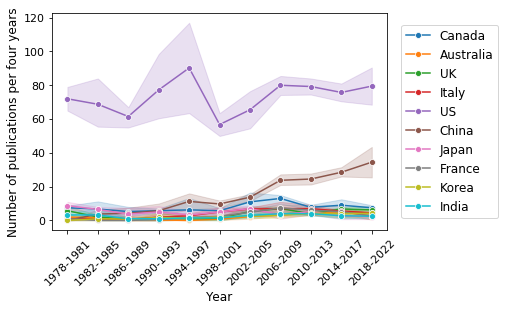

In [136]:
import seaborn as sns

# var = 'Type'
# var = 'Organization'
var = 'Country'
df = count_df(var,aff).sort_values(['Count'], ascending = False).reset_index(drop = True)
df_year = count_year_df(var,aff)

df_year = conv_year(df_year)
if var == 'Type':
    df_year = df_year[df_year[var] != 'Unknown']
else:
    df_year = df_year[df_year[var].isin(list(df[var])[0:10])]

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
sns.lineplot(x = "Year", y = "Count", hue = var, data=df_year, marker="o")
plt.xticks(rotation = 45, fontsize=11)
plt.yticks(fontsize=11)
handles, labels = ax.get_legend_handles_labels()
labels = labels[1:]
if var == 'Country':
    x = 1.35
elif var == 'Type':
    x = 1.5
else:
    x = 1.75
legend = plt.legend(labels, bbox_to_anchor=(x, 0.5), loc = 'right',  fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of publications per four years",fontsize=12)
plt.savefig('plots/'+var+' year.png', dpi = 400, bbox_inches='tight')
plt.show()

# Visualization on world map

In [138]:
##get the country code for each country
df_ctry = count_df('Country',aff)
ct_name = {'China (Taiwan)': 'China', 'US': 'United States', 'UK': 'United Kingdom','Czech Republic':'Czech',
           'korea': 'Korea'}

for key in ct_name.keys():
    df_ctry = df_ctry.replace(key, ct_name[key])
    
df_ctry['CODE']=alpha3code(df_ctry.Country)

for idx, row in df_ctry.iterrows():
    code = row['CODE']
    ct = row['Country']
    if code == 'None':
        df_ctry.loc[idx, 'CODE'] = get_country_code(ct)

In [143]:
##prepare the geometric data for visualziation on the world map
'''
ref source:
1. https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b
2. Revise and corrections are needed for data: world, locaction
'''
import geopandas
# first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# # rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']

##add a few missing countries: e.g. Singapore
# world_map = {'Singapore': [5686000, 'Asia', 'Singapore', 462304,]}
# for key in world_map.keys():
#     idx = len(world)
#     world.loc[idx, 'name'] = key
#     world.loc[idx, 'latitude'] = loc_map[key][0]
#     world.loc[idx, 'longitude'] = loc_map[key][1]

#correct the code for a few countries
code_map = {'France': 'FRA','Norway': 'NOR'}
for key in code_map.keys():
    tmp = world[world['name'] == key]
    idx = list(tmp.index)[0]
    world.loc[idx,'CODE'] = code_map[key]
    
# then merge with our data 
print (len(df_ctry))
merge=pd.merge(world,df_ctry,on='CODE')
print (len(merge))
# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')

##add the info for a few countries
loc_map = {'France': [46.2276, 2.2137], "Singapore": [1.3521, 103.8198], 'Puerto Rico': [18.2208, 66.5901]}
for key in loc_map.keys():
    idx = len(location)
    location.loc[idx, 'name'] = key
    location.loc[idx, 'latitude'] = loc_map[key][0]
    location.loc[idx, 'longitude'] = loc_map[key][1]

merge=merge.merge(location,on='name')#.sort_values(by='Count',ascending=False).reset_index()
print (len(merge))

66
65
65


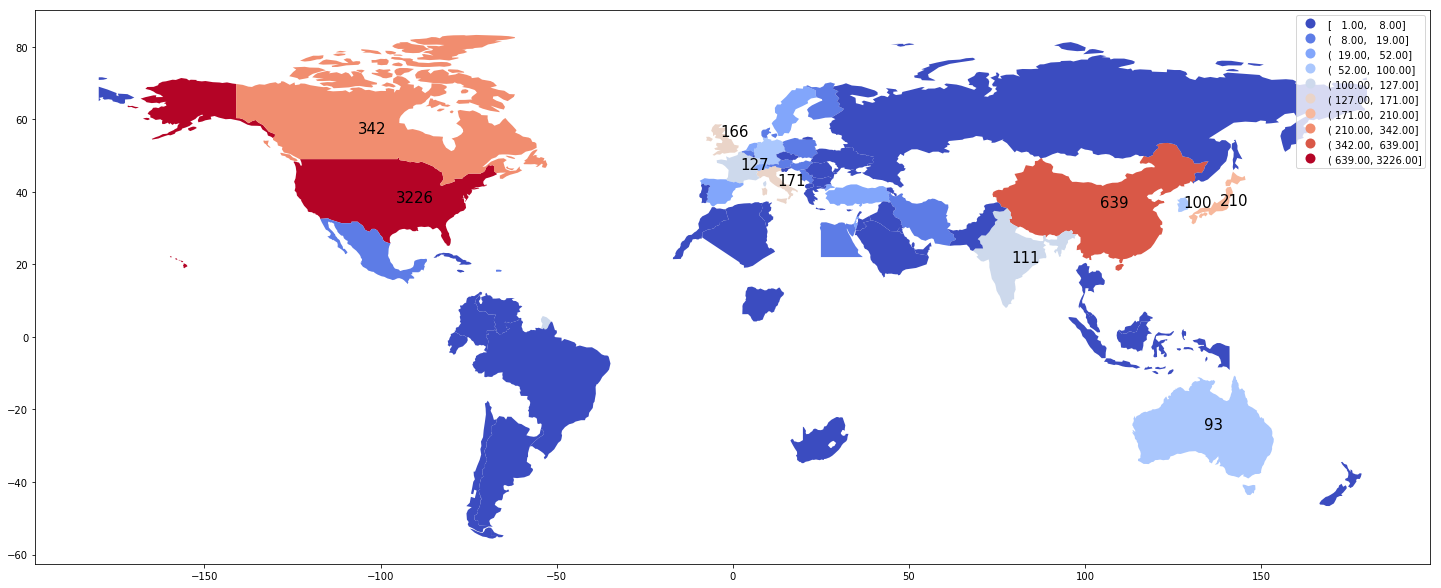

In [151]:
# plot confirmed cases world map 
'''
Options for "scheme":
   1. 'equal_interval': mapclassify.EqualInterval,
   2. 'fisher_jenks': mapclassify.FisherJenks,
   3. 'jenks_caspall': mapclassify.JenksCaspall,
   4.  'jenks_caspall_forced': mapclassify.JenksCaspallForced,
   5.  'maximum_breaks': mapclassify.MaximumBreaks,
   6.  'natural_breaks': mapclassify.NaturalBreaks,
   7. 'quantiles': mapclassify.Quantiles,
ref source: 1. https://nbviewer.org/github/pysal/mapclassify/blob/master/notebooks/03_choropleth.ipynb
2. https://pysal.org/mapclassify/
3. https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html
4. https://geopandas.org/en/stable/docs/user_guide/mapping.html
'''
# fig, ax = plt.subplots()
# fig.set_size_inches(6, 4)
merge = merge.sort_values(['Count'],ascending = False).reset_index(drop = True)

merge.plot(column='Count', scheme="fisher_jenks",k=10,
           figsize=(25, 20),
           legend=True,cmap='coolwarm')
# add countries names and numbers 
for i in range(0,10):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}".format(merge.Count[i]),size=15)
plt.savefig('plots/world.jpg')
plt.show()

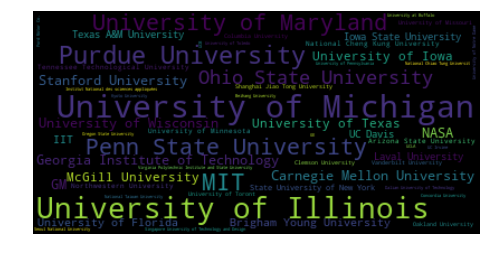

In [178]:
df_org = count_df('Organization',aff)
df_org = df_org.sort_values(['Count'], ascending = False)

dictx = {}
for v1, v2 in df_org.values:
    dictx[v1] = v2

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=dictx)
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.savefig('plots/wordcloud_topic.png', dpi = 1000, bbox_inches='tight')
plt.savefig('plots/wordcloud_organization.png', dpi = 1000, bbox_inches='tight')
plt.show()

# publication

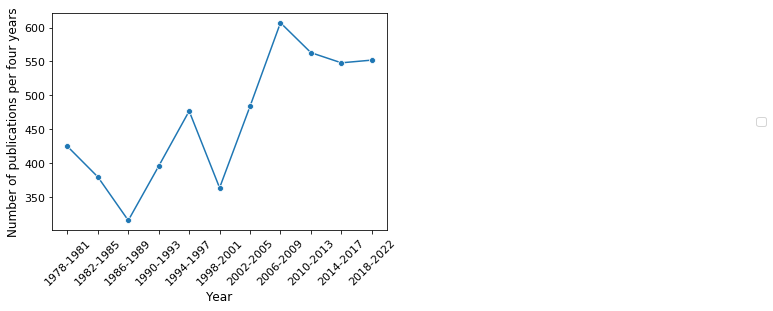

In [215]:
cluster_data = conv_year(cluster_data)
pub_cnt = pd.DataFrame({'count': cluster_data.groupby(by=['Year'])['title'].count()}).reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
sns.lineplot(x = "Year", y = "count", data=pub_cnt, marker="o")
plt.xticks(rotation = 45, fontsize=11)
plt.yticks(fontsize=11)
handles, labels = ax.get_legend_handles_labels()
for i in range(0,len(labels)):
    labels[i] = sec_name_dict[labels[i]]
legend = plt.legend(labels, bbox_to_anchor=(2.15, 0.5), loc = 'right',  fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of publications per four years",fontsize=12)
plt.savefig('plots/publication year.png', dpi = 400, bbox_inches='tight')
plt.show()

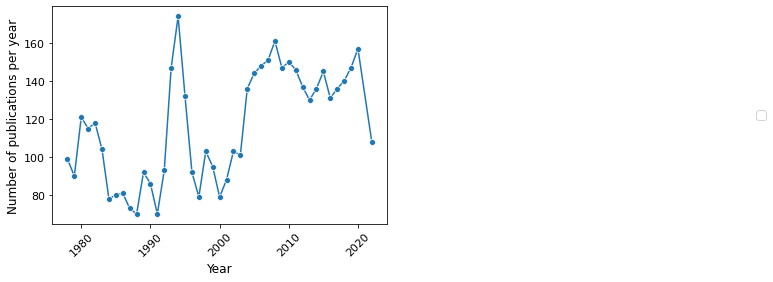

In [526]:
pub_cnt = pd.DataFrame({'count': cluster_data.groupby(by=['year'])['title'].count()}).reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
sns.lineplot(x = "year", y = "count", data=pub_cnt, marker="o")
plt.xticks(rotation = 45, fontsize=11)
plt.yticks(fontsize=11)
handles, labels = ax.get_legend_handles_labels()
for i in range(0,len(labels)):
    labels[i] = sec_name_dict[labels[i]]
legend = plt.legend(labels, bbox_to_anchor=(2.15, 0.5), loc = 'right',  fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of publications per year",fontsize=12)
plt.savefig('plots/publication year 1.png', dpi = 400, bbox_inches='tight')
plt.show()

# author

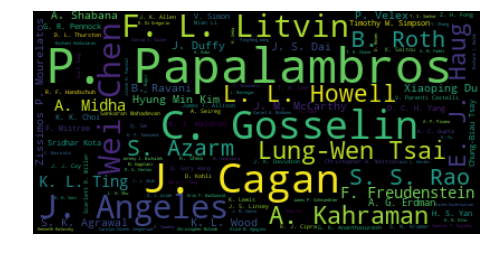

In [184]:
df_auth = count_df('author_id',auth)
df_auth = df_auth.sort_values(['Count'], ascending = False)

for idx,row in df_auth.iterrows():
    tmp = auth[auth['author_id'] == row['author_id']]
    df_auth.loc[idx,'Name'] = tmp['Name'].values[0]
    
dictx = {}
for v1, v2, v3 in df_auth.values:
    dictx[v3] = v2

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=dictx)
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.savefig('plots/wordcloud_topic.png', dpi = 1000, bbox_inches='tight')
plt.savefig('plots/wordcloud_author.png', dpi = 1000, bbox_inches='tight')
plt.show()

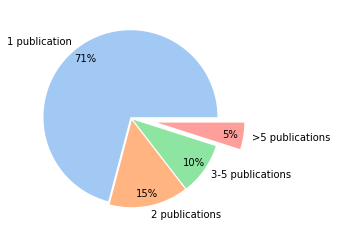

In [202]:
count = [0, 1, 2, 5]

no_pub,label = get_percent(df_auth, 'publication', count)
            
# Seaborn color palette to plot pie chart
colors = sns.color_palette('pastel')
explode = [0.02,0.02,0.02,0.3]

fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
# create pie chart using matplotlib
plt.pie(no_pub, labels=label, colors=colors, autopct = '%0.00f%%', pctdistance=0.85, labeldistance=1.1, explode = explode)
plt.savefig('plots/author pie chart.png', dpi = 400, bbox_inches='tight')
plt.show()

# Citation

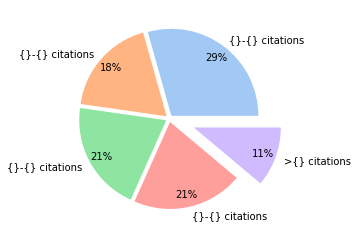

In [210]:
import re

cite = list(cluster_data['cited times'])
cit = []
for i in cite:
    no = 0
    txt = i.split(';')
    for j in txt:
        digit = re.findall(r'\d+', j)
        if len(digit) > 0:
            no += int(digit[0])
    cit = cit + [no]
    
cluster_data['Count'] = cit

count = [0, 5, 10, 20, 50]

no_cit,label = get_percent(cluster_data, 'citation', count)
            
# Seaborn color palette to plot pie chart
colors = sns.color_palette('pastel')
explode = list(0.04*np.ones(len(label)))
explode[-1] = 0.3

fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
# create pie chart using matplotlib
plt.pie(no_cit, labels=label, colors=colors, autopct = '%0.00f%%', pctdistance=0.85, labeldistance=1.1, explode = explode)
plt.savefig('plots/citation pie chart.png', dpi = 400, bbox_inches='tight')
plt.show()

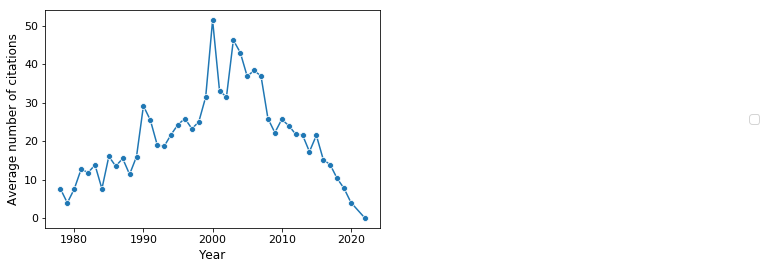

In [211]:
cluster_data = 
cit_avg = pd.DataFrame({'Average': cluster_data.groupby(by=['year'])['Number of Citations'].mean()}).reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
sns.lineplot(x = "year", y = "Average", data=cit_avg, marker="o")
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
handles, labels = ax.get_legend_handles_labels()
for i in range(0,len(labels)):
    labels[i] = sec_name_dict[labels[i]]
legend = plt.legend(labels, bbox_to_anchor=(2.15, 0.5), loc = 'right',  fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average number of citations",fontsize=12)
plt.savefig('plots/citation year mean 1.png', dpi = 400, bbox_inches='tight')
plt.show()

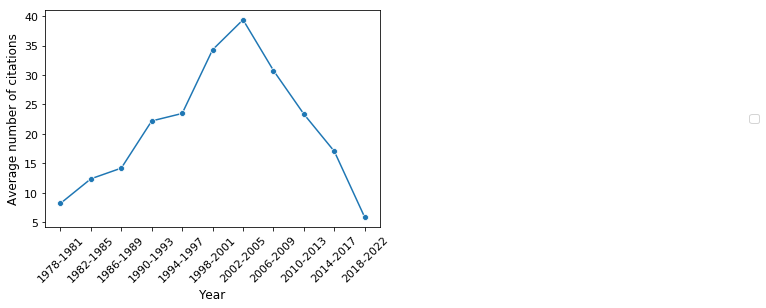

In [216]:
cit_avg = pd.DataFrame({'Average': cluster_data.groupby(by=['Year'])['Number of Citations'].mean()}).reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
sns.lineplot(x = "Year", y = "Average", data=cit_avg, marker="o")
plt.xticks(rotation = 45, fontsize=11)
plt.yticks(fontsize=11)
handles, labels = ax.get_legend_handles_labels()
for i in range(0,len(labels)):
    labels[i] = sec_name_dict[labels[i]]
legend = plt.legend(labels, bbox_to_anchor=(2.15, 0.5), loc = 'right',  fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average number of citations",fontsize=12)
plt.savefig('plots/citation year mean.png', dpi = 400, bbox_inches='tight')

'''
Papers from 2002-2005 are most cited on average. Why?
'''
plt.show()

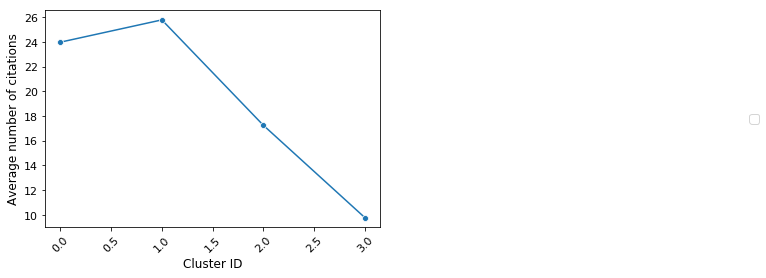

In [219]:
cit_avg = pd.DataFrame({'Average': cluster_data.groupby(by=['cluster_4'])['Number of Citations'].mean()}).reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
sns.lineplot(x = "cluster_4", y = "Average", data=cit_avg, marker="o")
plt.xticks(rotation = 45, fontsize=11)
plt.yticks(fontsize=11)
handles, labels = ax.get_legend_handles_labels()
for i in range(0,len(labels)):
    labels[i] = sec_name_dict[labels[i]]
legend = plt.legend(labels, bbox_to_anchor=(2.15, 0.5), loc = 'right',  fontsize=12)
plt.xlabel("Cluster ID", fontsize=12)
plt.ylabel("Average number of citations",fontsize=12)
plt.savefig('plots/citation cluster mean.png', dpi = 400, bbox_inches='tight')
'''
Papers from clusters 0 and 1 are most cited on average.
'''
plt.show()

# cluster

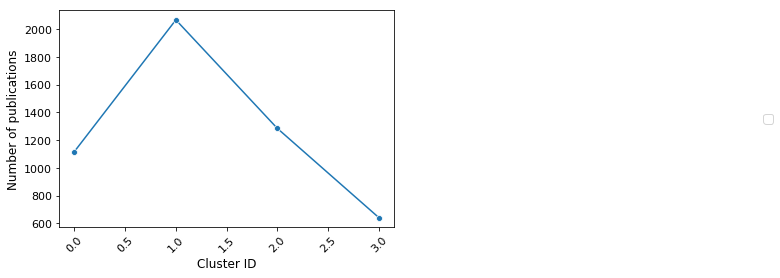

In [224]:
pub_cnt = pd.DataFrame({'count': cluster_data.groupby(by=['cluster_4'])['title'].count()}).reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
sns.lineplot(x = "cluster_4", y = "count", data=pub_cnt, marker="o")
plt.xticks(rotation = 45, fontsize=11)
plt.yticks(fontsize=11)
handles, labels = ax.get_legend_handles_labels()
for i in range(0,len(labels)):
    labels[i] = sec_name_dict[labels[i]]
legend = plt.legend(labels, bbox_to_anchor=(2.15, 0.5), loc = 'right',  fontsize=12)
plt.xlabel("Cluster ID", fontsize=12)
plt.ylabel("Number of publications", fontsize=12)
plt.savefig('plots/publication cluster.png', dpi = 400, bbox_inches='tight')
'''
Cluster 1 contains most papers.
'''
plt.show()

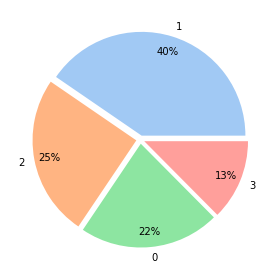

In [225]:
cluster_count = pd.DataFrame({'Frequency': cluster_data.groupby(by=['cluster_4'])['title'].count()}).reset_index()
cluster_count = cluster_count.sort_values(['Frequency'], ascending = False)

# Seaborn color palette to plot pie chart
colors = sns.color_palette('pastel')
explode = list(0.04*np.ones(len(cluster_count)))

fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
# create pie chart using matplotlib
plt.pie(cluster_count['Frequency'], labels=cluster_count['cluster_4'], colors=colors, autopct = '%0.00f%%', \
        pctdistance=0.85, labeldistance=1.1, explode = explode)
plt.tight_layout()
plt.savefig('plots/cluster pie chart.png', dpi = 400, bbox_inches='tight')
plt.show()

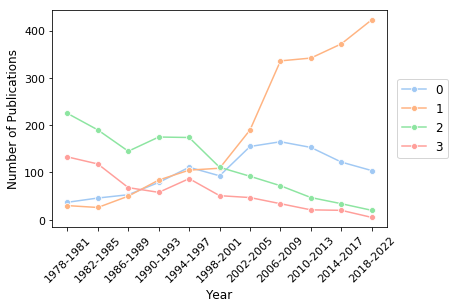

In [230]:
var = 'cluster_4'
section_year = pd.DataFrame({'Number of Publications': cluster_data.groupby([var, 'Year'])['title'].count()}).reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
palette = sns.color_palette('pastel', 4)
sns.lineplot(x = "Year", y = "Number of Publications", hue=var, data = section_year, marker="o", palette = palette)
plt.xticks(rotation = 45, fontsize=11)
plt.yticks(fontsize=11)
handles, labels = ax.get_legend_handles_labels()
# for i in range(0,len(labels)):
#     labels[i] = sec_name_dict1[labels[i]]
legend = plt.legend(labels[1:], bbox_to_anchor=(1.2, 0.5), loc = 'right',  fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Publications",fontsize=12)
plt.savefig('plots/cluster evolution.png', dpi = 400, bbox_inches='tight')
'''while 
Cluster(s) 1 (and 2) is (are) increasing, while clusters 2 and 3 are decreasing.
'''
plt.show()

In [231]:
len(labels)

5

In [232]:
topic_list2 = ['Design','Optimization','Kinematics','Algorithms','Errors','Manufacturing','Linkages','Modeling',\
 'Simulation','Reliability','Uncertainty','Probability','Failure','Linkages','Splines','Springs','Polynomials'] #,'Vibration','Stress','Gears','Stiffness','Modeling'

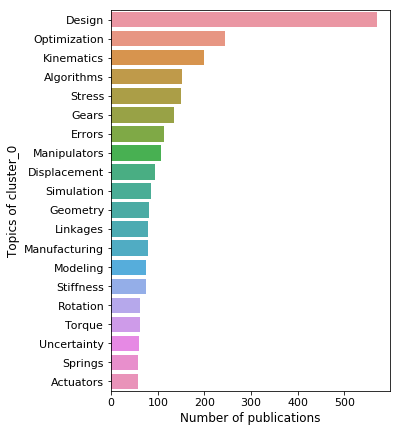

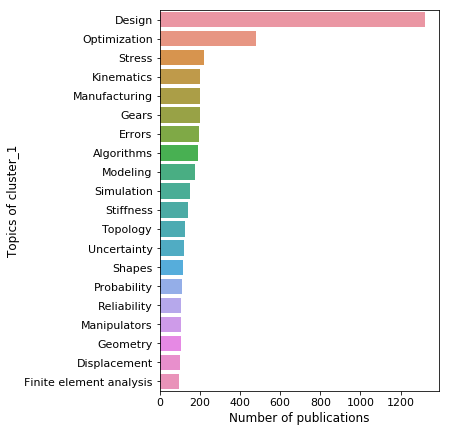

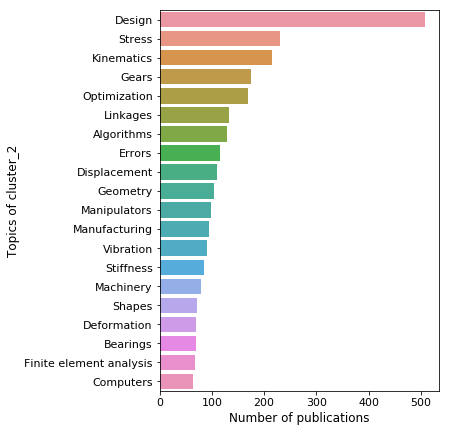

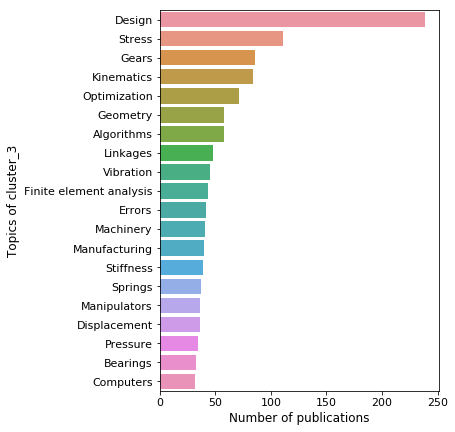

In [251]:
##topic
for i in range(0,4):
    cluster_data_i = cluster_data[cluster_data['cluster_4'] == i]
    proc_data_i = process_data(cluster_data_i)
    topic_dict_i = dictdata(proc_data_i['topics'])
    topic_freq_dist_i = pd.DataFrame(list(topic_dict_i.items()), columns = ["Topic","Frequency"])
    
    topic_freq_dist_i = topic_freq_dist_i.sort_values(['Frequency'], ascending = False).reset_index(drop = True)
    topic1 = topic_freq_dist_i[0:20]

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 7)
    ax = sns.barplot(y="Topic", x="Frequency", data=topic1)
    plt.yticks(rotation = 0, fontsize=11)
    plt.xticks(fontsize=11)
    plt.ylabel("Topics of cluster_{}".format(i), fontsize=12)
    plt.xlabel("Number of publications", fontsize=12)
    plt.savefig('plots/topic bar chart_{}.png'.format(i), dpi = 400, bbox_inches='tight')
    plt.show()

# topic

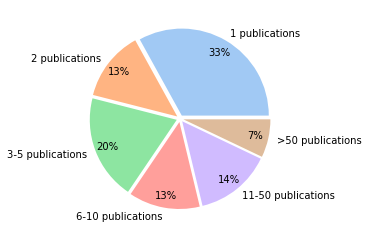

In [234]:
topic = pd.read_csv('topic_freq_dist.csv')

topic_count = pd.DataFrame({'Count': topic.groupby(by=['Topic'])['Frequency'].sum()})
topic_count = topic_count.sort_values(['Count'], ascending = False)
count = [1, 2, 5, 10, 50]

no_pub = []
label = []
for i in range(0,len(count)+1):
    if i == len(count):
        df = topic_count[topic_count['Count'] > count[i-1]]
        no_pub = no_pub + [len(df)]
        label = label + ['>{} publications'.format(count[i-1])]
    elif i == 0:
        df = topic_count[topic_count['Count'] == count[i]]
        no_pub = no_pub + [len(df)]
        label = label + ['{} publications'.format(count[i])]
    else:
        df = topic_count[(topic_count['Count'] > count[i-1]) & (topic_count['Count'] <= count[i])]
        no_pub = no_pub + [len(df)]
        if count[i] - count[i-1] == 1:
            if count[i] == 1:
                label = label + ['{} publication'.format(count[i])]
            else:
                label = label + ['{} publications'.format(count[i])]
        else:
            label = label + ['{}-{} publications'.format(count[i-1]+1, count[i])]
            
# Seaborn color palette to plot pie chart
colors = sns.color_palette('pastel')
explode = list(0.04*np.ones(len(label)))

fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
# create pie chart using matplotlib
plt.pie(no_pub, labels=label, colors=colors, autopct = '%0.00f%%', pctdistance=0.85, labeldistance=1.1, explode = explode)
plt.savefig('plots/topic pie chart.png', dpi = 400, bbox_inches='tight')
plt.show()

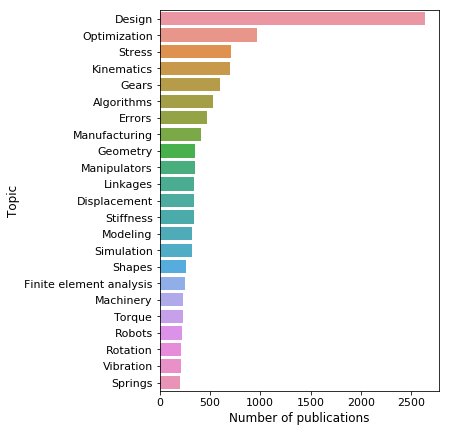

In [235]:
topic = topic.sort_values(['Frequency'], ascending = False).reset_index(drop = True)
topic1 = topic[topic['Frequency'] >= 200]

fig, ax = plt.subplots()
fig.set_size_inches(5, 7)
ax = sns.barplot(y="Topic", x="Frequency", data=topic1)
plt.xticks(rotation = 0, fontsize=11)
plt.yticks(fontsize=11)
# handles, labels = ax.get_legend_handles_labels()
# for i in range(0,len(labels)):
#     labels[i] = sec_name_dict[labels[i]]
# legend = plt.legend(labels, bbox_to_anchor=(2.15, 0.5), loc = 'right',  fontsize=12)
plt.ylabel("Topic", fontsize=12)
plt.xlabel("Number of publications", fontsize=12)
plt.savefig('plots/topic bar chart.png', dpi = 400, bbox_inches='tight')
plt.show()

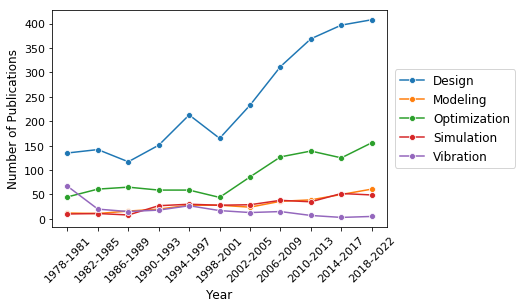

In [237]:
topic_year_dist = conv_year(topic_year_dist)

topic_list = ['Design', 'Optimization', 'Simulation', 'Vibration', 'Modeling']#, 'Shapes']
topic_list1 = list(topic1['Topic'])
topic_year_dist1 = topic_year_dist[topic_year_dist['Topic'].isin(topic_list)]
var = 'Year'
topic_year_cnt = pd.DataFrame({'Count': topic_year_dist1.groupby(by=[var,'Topic'])['Frequency'].sum()}).reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
palette = sns.color_palette('pastel', len(topic_list))
sns.lineplot(x = var, y = "Count", data = topic_year_cnt, hue= "Topic", marker="o", ci=None)
plt.xticks(rotation = 45, fontsize=11)
plt.yticks(fontsize=11)
handles, labels = ax.get_legend_handles_labels()
# for i in range(0,len(labels)):
#     labels[i] = sec_name_dict1[labels[i]]
legend = plt.legend(labels[1:], bbox_to_anchor=(1.4, 0.5), loc = 'right',  fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Publications",fontsize=12)
plt.savefig('plots/topic evolution.png', dpi = 400, bbox_inches='tight')
plt.show()